In [1]:
# All Imports
import sys 
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
#from sklearn.cluster import DBSCAN
#import collections
#from sklearn.neighbors import NearestNeighbors
#from gensim.test.utils import common_texts
import pickle

#from gensim.models.doc2vec import Doc2Vec, TaggedDocument,KeyedVectors 
#from gensim.test.utils import get_tmpfile
#import nltk
#from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

from sklearn.cluster import KMeans

In [2]:
test_documents_json = pickle.load( open( "counted_bows_test", "rb" ) ) #test_documents
print(len(test_documents_json))
train_documents_json = pickle.load( open( "counted_bows", "rb" ) ) #train_documents
print(len(train_documents_json))

10969
123984


In [3]:
train_documents = [TaggedDocument(i[0],i[1]) for i in train_documents_json]
test_documents = [TaggedDocument(i[0],i[1]) for i in test_documents_json]
print(train_documents[123])

TaggedDocument(['love', 'rememb', 'littl', 'when', 'into', 'gone', 'spring', 'smile', 'rememb', 'everi', 'see', 'eye', 'love', 'dawn', 'teardrop', 'shadow', 'dream', 'now', 'thing', 'kiss', 'far', 'love', 'was', 'color', 'star', 'lip', 'smile', 'look', 'shadow', 'thing', 'too', 'light', 'did', 'our', 'smile', 'high', 'when', 'love', 'littl'], ['1126283'])


In [3]:
nltk.download(["stopwords", "averaged_perceptron_tagger", "vader_lexicon"])

[nltk_data] Downloading package stopwords to /home/lilli/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lilli/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lilli/nltk_data...


True

In [3]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords.append(nltk.corpus.stopwords.words("spanish"))
stopwords.append(nltk.corpus.stopwords.words("german"))
stopwords.append(nltk.corpus.stopwords.words("dutch"))
stopwords.append(nltk.corpus.stopwords.words("french"))
stopwords.append(nltk.corpus.stopwords.words("italian"))
def remove_stopwords(doc_corpus):
    new_corp = []
    for doc in doc_corpus:
        words = [w for w in doc[0] if w.lower() not in stopwords]
        if len(words) == 0:
            print("removed")
        else:
            new_corp.append([words,doc[1]])
    return new_corp

docs = remove_stopwords(train_documents_json)
print(len(docs))

123984


In [20]:
test_dict = {i[1][0]:i for i in test_documents_json}

In [ ]:
all_words = [item for sublist in docs for item in sublist[0]]

frequency_distribution = nltk.FreqDist(all_words)
print(frequency_distribution.most_common(5))

In [148]:
def add_freq_dist(doc_corpus):
    tfidf_dict = {} 
    for doc in doc_corpus:
        freq_dist_doc = nltk.FreqDist(doc[0])
        tfidf = [[w, freq_dist_doc[w]/frequency_distribution[w] ] for w in list(set(doc[0]))]
        tfidf_dict[doc[1][0]] = tfidf
    return tfidf_dict
with_tfidf = add_freq_dist(docs)  


In [35]:
corpus = [' '.join(x[0]) for x in docs]
vectorizer = TfidfVectorizer()
tfidf_x = vectorizer.fit_transform(corpus)

In [40]:
df_countvect = pd.DataFrame(data= tfidf_x.toarray(), index=[i[1][0] for i in docs], columns=vectorizer.get_feature_names() )

In [94]:
train_documents = [TaggedDocument(i[0],[i[1][0]]) for i in docs]
modeld2v = Doc2Vec(documents=train_documents, vector_size=10, epochs=3, min_count=2, workers=6)
modeld2v.save("stopwords_removed.model")

In [95]:
modeld2v.train(train_documents, total_examples=modeld2v.corpus_count, epochs=100)
modeld2v.save("stopwords_removed.model")

In [169]:
inferred_vectors_dict = {docs[i][1][0]: inferred_vectors[i] for i in range(len(docs))}
with open("inferred_vectors_dict.p","wb") as inf_json:
    pickle.dump(inferred_vectors_dict,inf_json)
inf_json.close()

In [2]:
inferred_vectors = pickle.load( open( "inferred_vectors_dict.p", "rb" ) )
X = np.array(list(inferred_vectors.values()))


In [3]:
kmeans_model = KMeans(init='k-means++', n_clusters=30, n_init=10)
kmeans_model.fit(X)
clustering  = kmeans_model.labels_

#X_embedded = TSNE(n_components=2, perplexity=200).fit_transform(X)
#X_embedded.shape



In [4]:
corpus = [' '.join(x[0]) for x in docs]
vectorizer = TfidfVectorizer()
tfidf_x = vectorizer.fit_transform(corpus)
df_countvect = pd.DataFrame(data= tfidf_x.todense(), index=[i[1][0] for i in docs], columns=vectorizer.get_feature_names() )

with open("tfidf_df.p","wb") as inf_json:
    pickle.dump(df_countvect,inf_json)

In [5]:
df_countvect = pickle.load( open( "tfidf_df.p", "rb" ) )

clust_df = pd.DataFrame({'cluster': clustering}, index=[i for i in inferred_vectors.keys()])
new_df = df_countvect.join(clust_df)
with open("tfidf_df.p","wb") as inf_json:
    pickle.dump(new_df,inf_json)

In [2]:
df_countvect = pickle.load( open( "tfidf_df.p", "rb" ) )

In [74]:
np.shape(df_countvect)

NameError: name 'df_countvect' is not defined

In [7]:
def compute_all_with_topwords(n_clust=20, length=1000, new_clustering=False):
    # load data
    # vectors from doc2vec model doc_id: [vector]
    inferred_vectors_dict = pickle.load( open( "inferred_vectors_dict.p", "rb" ) )
    # tf-idf matrix: doc_id w1 w2 ... wn
    df_countvect = pickle.load( open( "tfidf_df.p", "rb" ) )
    
    # np array of vectors
    X = np.array(list(inferred_vectors_dict.values()))[:length]
    
    # apply t-SNE
    X_embedded = TSNE(n_components=2, perplexity=200).fit_transform(X)
    X_embedded.shape  
    
    clustering = list(df_countvect['cluster'].to_numpy())[:length]
    if new_clustering:
        # cluster
        kmeans_model = KMeans(init='k-means++', n_clusters=n_clust, n_init=10)
        kmeans_model.fit(X)
        clustering  = kmeans_model.labels_

        # join clusters and tf-idf
        clust_df = pd.DataFrame({'cluster': clustering}, index=[i for i in inferred_vectors.keys()])
        df_countvect = df_countvect.join(clust_df)
    
    labels = []
    for i in range(n_clust):
        cluster = df_countvect.loc(0)[df_countvect.loc(1)['cluster'] == i]
        cluster_mean = cluster.mean()
        top_words = cluster_mean.sort_values()
        labels.append(top_words[-20:-10])
    return X_embedded, clustering, labels
        
#tsneData,clusters,labels = compute_all_with_topwords(n_clust=20, length=5000)        

In [70]:
def draw_all(data, clusters, labels, n_clust=20):

    plt.figure(figsize=(25, 25))

    plt.scatter([i[0] for i in data],[i[1] for i in data],c=clusters[:len(data)],cmap='tab20', s=30)
    
    minx = min(*[i[0] for i in data])
    maxy = max(*[i[1] for i in data])
    i_step = (maxy)/n_clust *0.5
    
    plt.scatter([minx for i in range(n_clust)],[maxy - i*i_step for i in range(n_clust)],c=list(range(0,n_clust)), cmap='tab20', s=30, marker="s")
    for i in list(range(0,n_clust)):
        txt = labels[i].index.values
        plt.annotate(', '.join(txt), (minx + 0.1*i_step, maxy - i*i_step))

In [78]:
tsneData,clusters,labels = compute_all_with_topwords(n_clust=20, length=20000) 

KeyboardInterrupt: 

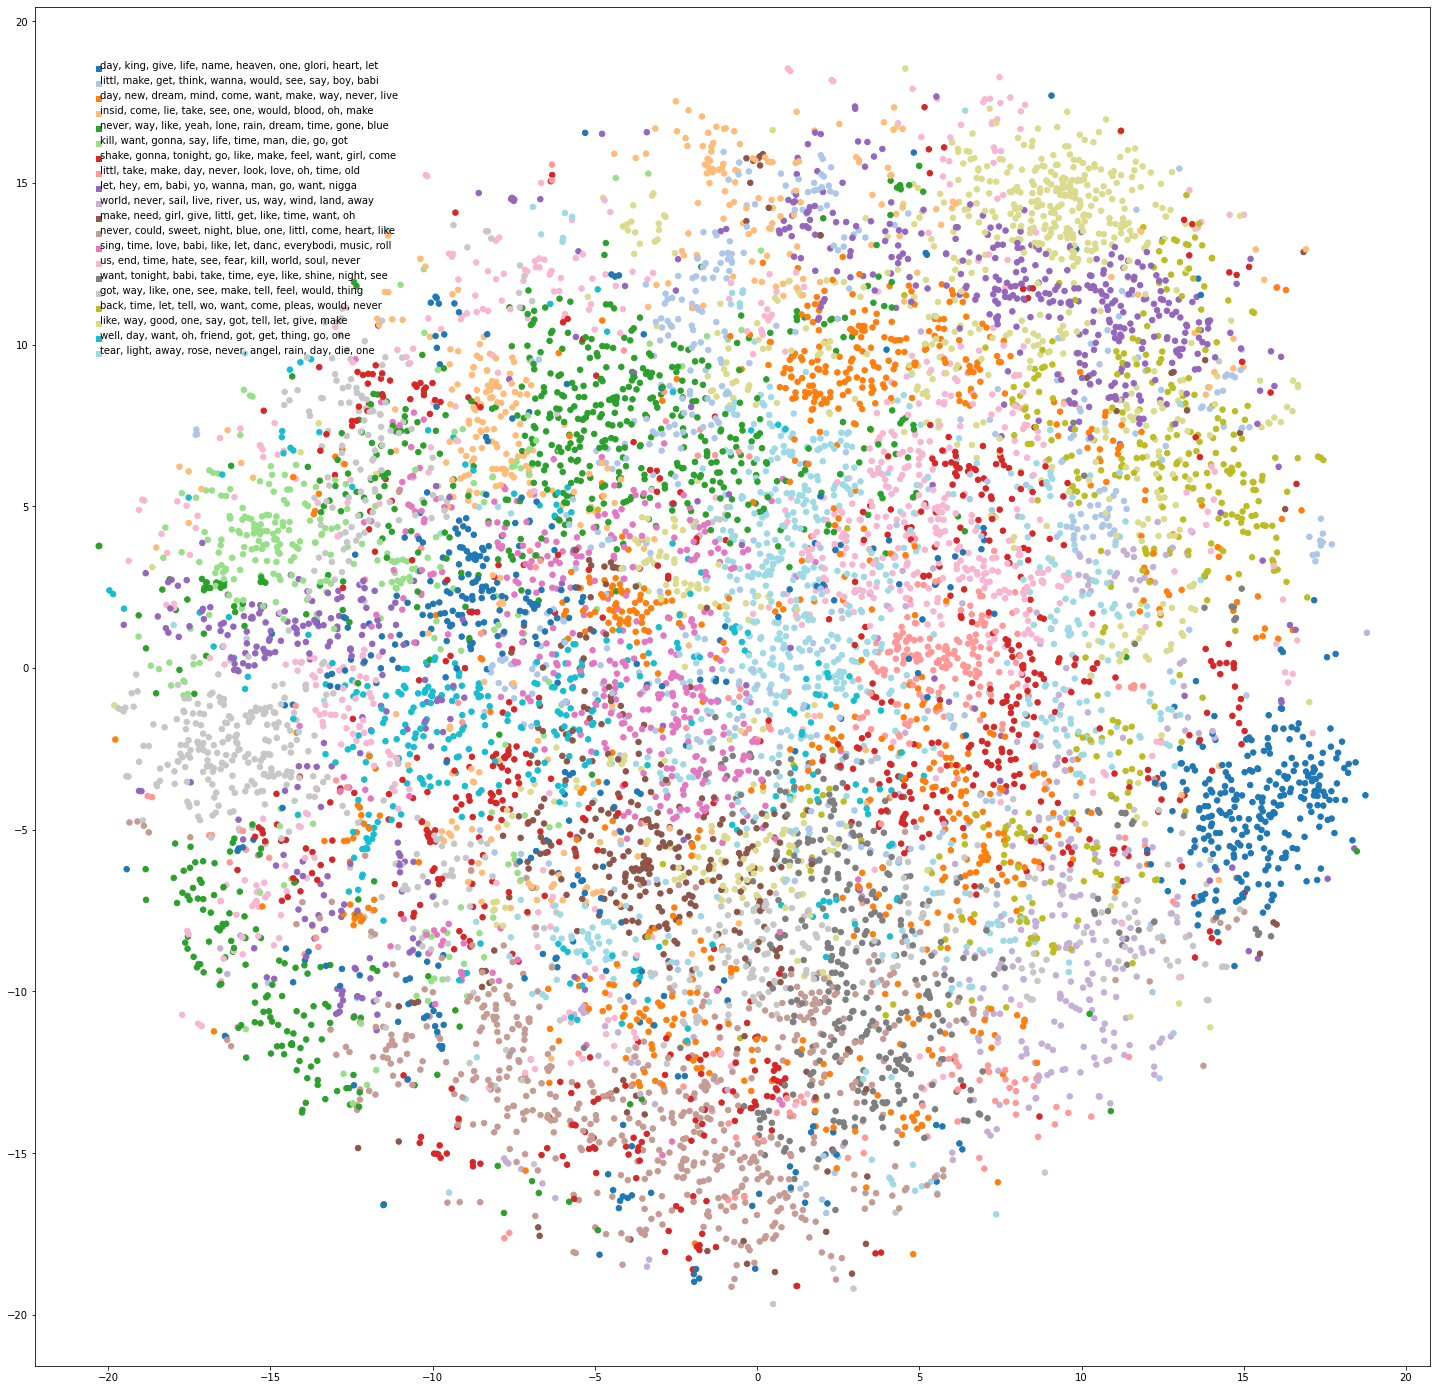

In [79]:
draw_all(tsneData,clusters,labels, len(labels))

In [128]:
sia_scores = pickle.load( open( "sia_scores.p", "rb" ) ) #test_documents
X = np.array([list(sia_scores[i].values()) for i in sia_scores.keys()])

In [122]:
def find_closest(document_id):
    np_scores = {k: v.values() for (k,v) in sia_scores.items()}
    sia_score_doc = np_scores[document_id]
    closest = [float('inf'), '']
    for (k,v) in np_scores.items():
        new_dist = np.linalg.norm(np.array(list(sia_score_doc))-np.array(list(v)))
        if new_dist != 0 and new_dist < closest[0]:
            closest = [new_dist, k]
    print(with_tfidf[closest[1]])
    print("\n")
    print(with_tfidf[document_id])
    return closest

In [121]:
def paint_test_genres():
    test_ids = [i[1][0] for i in test_documents_json]
    inf_vecs = pickle.load( open( "inferred_vectors_dict.p", "rb" ) ) #test_documents
    test_vecs = [(inf_vecs[vec],test_dict[vec]) for vec in test_ids]
    X = np.array([i[0] for i in test_vecs])

    genres = [i[1][1][1] for i in test_vecs]
    counter = collections.Counter(genres)
    for i in range(len(genres)):
        if counter[genres[i]] < 55:
            genres[i] = 0
    unique_colors = sorted(list(set(genres)),key= lambda x: counter[x])
    colors = [unique_colors.index(i) for i in genres]

    X_embedded = TSNE(n_components=2, perplexity=200).fit_transform(X)

    with open('genres.json','r') as file2:
        genre_names = json.load(file2) 
    genre_mapping = {i: [x['name'] for x in genre_names if x['genre_id'] == i] for i in unique_colors}

    plt.figure(figsize=(25, 25))

    plt.scatter([i[0] for i in X_embedded],[i[1] for i in X_embedded],c=colors,cmap='tab20', s=20)

    plt.scatter([-60 for i in list(set(colors))],[(i-10)*2 for i in list(set(colors))],c=list(set(colors)), cmap='tab20', s=20)
    for i in range(len(unique_colors)):
        txt = genre_mapping[unique_colors[i]]
        plt.annotate(txt, (-59, (i-10)*2))

In [121]:
def sentiment_analyzer(documents):
    sia = SentimentIntensityAnalyzer()
    polarity_scores = {}
    for doc in documents:
        polarity_scores[doc[1][0]] = sia.polarity_scores(' '.join(set(doc[0])))
    return polarity_scores
polarity_scores = sentiment_analyzer(docs)
with open("sia_scores","wb") as test_json:
    pickle.dump(polarity_scores,test_json)
test_json.close()